## 1. Importar Bibliotecas

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import missingno as msno
from pathlib import Path

sys.path.append('../src')
from preprocessing import DataPreprocessor

plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


## 2. Carregar Dados

In [17]:
# Carregar os 3 datasets
data_dir = Path('../data')

datasets = {
    '2022': pd.read_csv(data_dir / 'PEDE2022.csv'),
    '2023': pd.read_csv(data_dir / 'PEDE2023.csv'),
    '2024': pd.read_csv(data_dir / 'PEDE2024.csv'),
}

for ano, df in datasets.items():
    print(f"📊 PEDE{ano}: {df.shape[0]:,} linhas × {df.shape[1]} colunas")

# Atalhos
df_2022, df_2023, df_2024 = datasets['2022'], datasets['2023'], datasets['2024']
print(f"\n✅ Variáveis: df_2022, df_2023, df_2024")

📊 PEDE2022: 860 linhas × 42 colunas
📊 PEDE2023: 1,014 linhas × 48 colunas
📊 PEDE2024: 1,156 linhas × 50 colunas

✅ Variáveis: df_2022, df_2023, df_2024


## 3. Análise de Valores Ausentes

In [7]:
# Calcular missing values para cada dataset
for ano, df in datasets.items():
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100

    missing_df = pd.DataFrame({
        'Coluna': missing.index,
        'Missing Count': missing.values,
        'Missing %': missing_pct.values
    }).sort_values('Missing %', ascending=False)

    cols_com_missing = missing_df[missing_df['Missing %'] > 0]
    print(f"\n{'='*60}")
    print(f"📊 PEDE{ano} — {len(cols_com_missing)} colunas com missing values")
    print(f"{'='*60}")
    if len(cols_com_missing) > 0:
        print(cols_com_missing.to_string(index=False))
    else:
        print("✅ Nenhum valor ausente!")


📊 PEDE2022 — 8 colunas com missing values
    Coluna  Missing Count  Missing %
    Inglês            577  67.093023
   Rec Av4            564  65.581395
Avaliador4            550  63.953488
  Pedra 20            537  62.441860
  Pedra 21            398  46.279070
Avaliador3            326  37.906977
     Matem              2   0.232558
    Portug              2   0.232558

📊 PEDE2023 — 36 colunas com missing values
        Coluna  Missing Count  Missing %
      Pedra 23           1014 100.000000
Rec Psicologia           1014 100.000000
      Indicado           1014 100.000000
    Atingiu PV           1014 100.000000
  Destaque IEG           1014 100.000000
  Destaque IDA           1014 100.000000
  Destaque IPV           1014 100.000000
Destaque IPV.1           1014 100.000000
       Rec Av2           1014 100.000000
       Rec Av3           1014 100.000000
       Rec Av4           1014 100.000000
       Rec Av1           1014 100.000000
            Ct           1014 100.000000
      

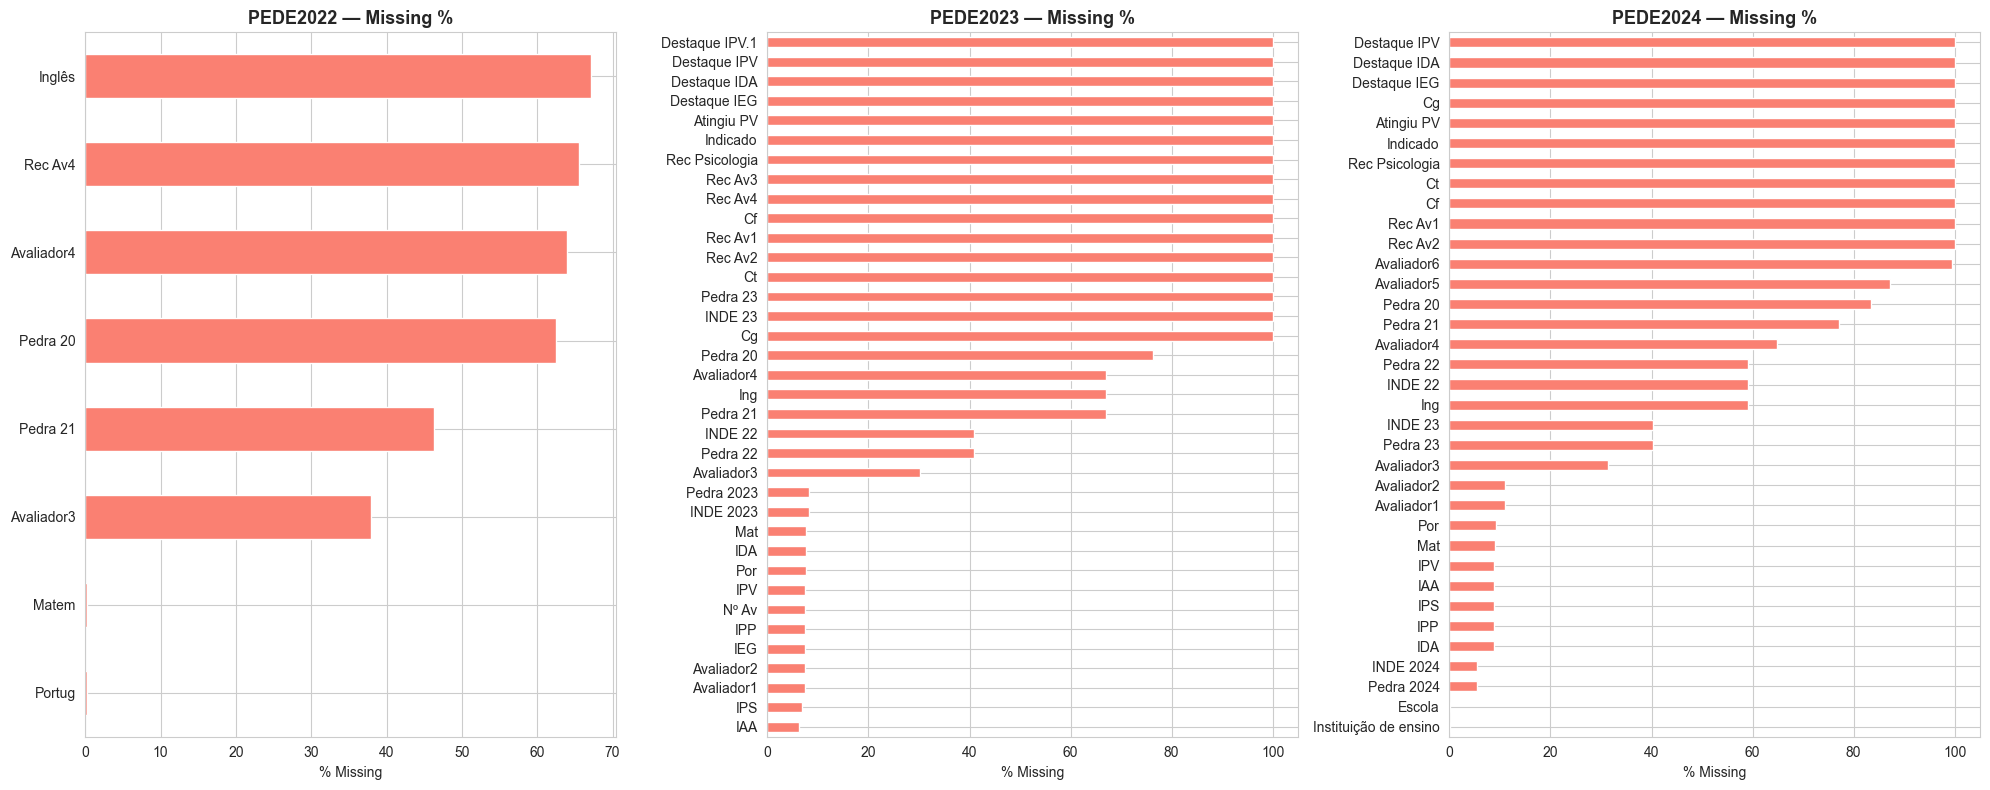

In [8]:
# Visualizar missing values por dataset
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (ano, df) in enumerate(datasets.items()):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    cols_missing = missing_pct[missing_pct > 0].sort_values(ascending=True)

    if len(cols_missing) > 0:
        cols_missing.plot(kind='barh', ax=axes[idx], color='salmon')
        axes[idx].set_title(f'PEDE{ano} — Missing %', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('% Missing')
    else:
        axes[idx].text(0.5, 0.5, 'Sem missing', ha='center', va='center', fontsize=14)
        axes[idx].set_title(f'PEDE{ano}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Análise de Tipos de Dados

In [9]:
# Tipos de dados por dataset
for ano, df in datasets.items():
    tipos = pd.DataFrame({
        'Coluna': df.columns,
        'Tipo': df.dtypes.values,
        'Non-Null': df.count().values,
        'Null': df.isnull().sum().values,
        'Unique': df.nunique().values
    })
    print(f"\n{'='*60}")
    print(f"📊 PEDE{ano} — Tipos de Dados")
    print(f"{'='*60}")
    print(tipos.to_string(index=False))


📊 PEDE2022 — Tipos de Dados
               Coluna    Tipo  Non-Null  Null  Unique
                   RA  object       860     0     860
                 Fase   int64       860     0       8
                Turma  object       860     0      24
                 Nome  object       860     0     860
             Ano nasc   int64       860     0      15
             Idade 22   int64       860     0      15
               Gênero  object       860     0       2
         Ano ingresso   int64       860     0       7
Instituição de ensino  object       860     0       3
             Pedra 20  object       323   537       4
             Pedra 21  object       462   398       4
             Pedra 22  object       860     0       4
              INDE 22 float64       860     0     745
                   Cg   int64       860     0     860
                   Cf   int64       860     0     192
                   Ct   int64       860     0      18
                Nº Av   int64       860     0       3

## 5. Detectar Valores Inconsistentes

In [10]:
# Verificar colunas numéricas com vírgulas (formato brasileiro) — por dataset
numeric_cols_map = {
    '2022': ['INDE 22', 'IAA', 'IEG', 'IPS', 'IDA', 'Matem', 'Portug', 'Inglês', 'IPV', 'IAN'],
    '2023': ['INDE 23', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'Mat', 'Por', 'Ing', 'IPV', 'IAN'],
    '2024': ['INDE 2024', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'Mat', 'Por', 'Ing', 'IPV', 'IAN'],
}

for ano, df in datasets.items():
    print(f"\n📊 PEDE{ano} — Valores com vírgula:")
    encontrou = False
    for col in numeric_cols_map.get(ano, []):
        if col in df.columns:
            has_comma = df[col].astype(str).str.contains(',').sum()
            if has_comma > 0:
                print(f"   ⚠️ {col}: {has_comma} valores com vírgula")
                encontrou = True
    if not encontrou:
        print("   ✅ Nenhum encontrado")


📊 PEDE2022 — Valores com vírgula:
   ✅ Nenhum encontrado

📊 PEDE2023 — Valores com vírgula:
   ✅ Nenhum encontrado

📊 PEDE2024 — Valores com vírgula:
   ✅ Nenhum encontrado


In [11]:
# Verificar valores fora do range esperado (0-10) — por dataset
for ano, df in datasets.items():
    print(f"\n🔍 PEDE{ano} — Valores fora do range (0-10):")
    encontrou = False
    for col in numeric_cols_map.get(ano, []):
        if col in df.columns:
            serie = df[col].astype(str).str.replace(',', '.', regex=False)
            serie = pd.to_numeric(serie, errors='coerce')
            out_of_range = ((serie < 0) | (serie > 10)).sum()
            if out_of_range > 0:
                print(f"   ⚠️ {col}: {out_of_range} valores fora do range")
                encontrou = True
    if not encontrou:
        print("   ✅ Todos dentro do range")


🔍 PEDE2022 — Valores fora do range (0-10):
   ✅ Todos dentro do range

🔍 PEDE2023 — Valores fora do range (0-10):
   ⚠️ IPV: 26 valores fora do range

🔍 PEDE2024 — Valores fora do range (0-10):
   ⚠️ IAA: 122 valores fora do range


## 6. Análise de Duplicatas

In [12]:
# Verificar duplicatas por dataset
for ano, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"\n📊 PEDE{ano}:")
    print(f"   Linhas duplicadas: {duplicates}")
    if 'RA' in df.columns:
        ra_dup = df['RA'].duplicated().sum()
        print(f"   RAs duplicados: {ra_dup}")


📊 PEDE2022:
   Linhas duplicadas: 0
   RAs duplicados: 0

📊 PEDE2023:
   Linhas duplicadas: 0
   RAs duplicados: 0

📊 PEDE2024:
   Linhas duplicadas: 0
   RAs duplicados: 0


## 7. Estatísticas Descritivas com Foco em Qualidade

In [13]:
# Estatísticas descritivas por dataset
for ano, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"📊 PEDE{ano} — Estatísticas Descritivas")
    print(f"{'='*60}")
    display(df.describe())


📊 PEDE2022 — Estatísticas Descritivas


,Fase,Ano nasc,Idade 22,Ano ingresso,INDE 22,Cg,Cf,Ct,Nº Av,IAA,IEG,IPS,IDA,Matem,Portug,Inglês,IPV,IAN,Defas
count,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,858.000000,858.000000,283.000000,860.000000,860.000000,860.000000
mean,2.098837,2009.861628,12.138372,2020.496512,7.036176,430.516279,75.519767,6.598837,3.054651,8.274419,7.891163,6.905000,6.092907,5.806876,6.320979,5.881272,7.253642,6.424419,-0.943023
std,1.788789,2.771998,2.771998,1.790217,1.017773,248.432761,52.312670,3.975858,0.775371,2.064935,1.638340,1.070707,2.046209,2.414215,2.080364,2.957315,1.093383,2.389609,0.845593
min,0.000000,2001.000000,7.000000,2016.000000,3.032000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,2.500000,2.500000,-5.000000
25%,1.000000,2008.000000,10.000000,2019.000000,6.485500,215.750000,30.000000,3.000000,2.000000,7.900000,7.000000,6.300000,4.800000,4.300000,5.200000,3.500000,6.722000,5.000000,-1.000000
50%,2.000000,2010.000000,12.000000,2021.000000,7.197000,430.500000,67.000000,6.000000,3.000000,8.800000,8.300000,7.500000,6.300000,6.000000,6.700000,6.300000,7.333000,5.000000,-1.000000
75%,3.000000,2012.000000,14.000000,2022.000000,7.751250,645.250000,118.000000,9.000000,4.000000,9.500000,9.100000,7.500000,7.600000,7.800000,7.800000,8.500000,7.917000,10.000000,0.000000
max,7.000000,2015.000000,21.000000,2022.000000,9.442000,862.000000,192.000000,18.000000,4.000000,10.000000,10.000000,10.000000,9.900000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000



📊 PEDE2023 — Estatísticas Descritivas


,INDE 2023,Ano ingresso,Pedra 23,INDE 22,INDE 23,Cg,Cf,Ct,Nº Av,Rec Av1,...,Ing,Indicado,Atingiu PV,IPV,IAN,Defasagem,Destaque IEG,Destaque IDA,Destaque IPV,Destaque IPV.1
count,931.000000,1014.000000,0.0,600.000000,0.0,0.0,0.0,0.0,938.000000,0.0,...,334.000000,0.0,0.0,938.000000,1014.000000,1014.000000,0.0,0.0,0.0,0.0
mean,7.342309,2021.378698,NaN,7.262788,NaN,NaN,NaN,NaN,3.109808,NaN,...,6.200299,NaN,NaN,8.027897,7.243590,-0.654832,NaN,NaN,NaN,NaN
std,0.901757,1.873750,NaN,0.895774,NaN,NaN,NaN,NaN,0.768712,NaN,...,2.236545,NaN,NaN,0.945427,2.539585,0.821233,NaN,NaN,NaN,NaN
min,3.745542,2016.000000,NaN,3.700000,NaN,NaN,NaN,NaN,2.000000,NaN,...,0.000000,NaN,NaN,3.320000,2.500000,-4.000000,NaN,NaN,NaN,NaN
25%,6.724150,2021.000000,NaN,6.740250,NaN,NaN,NaN,NaN,3.000000,NaN,...,4.725000,NaN,NaN,7.462500,5.000000,-1.000000,NaN,NaN,NaN,NaN
50%,7.408033,2022.000000,NaN,7.402500,NaN,NaN,NaN,NaN,3.000000,NaN,...,6.400000,NaN,NaN,8.045000,5.000000,-1.000000,NaN,NaN,NaN,NaN
75%,7.996083,2023.000000,NaN,7.903500,NaN,NaN,NaN,NaN,4.000000,NaN,...,7.800000,NaN,NaN,8.668750,10.000000,0.000000,NaN,NaN,NaN,NaN
max,9.371200,2023.000000,NaN,9.442000,NaN,NaN,NaN,NaN,4.000000,NaN,...,10.000000,NaN,NaN,10.010000,10.000000,2.000000,NaN,NaN,NaN,NaN



📊 PEDE2024 — Estatísticas Descritivas


,Idade,Ano ingresso,INDE 22,INDE 23,Cg,Cf,Ct,Nº Av,Rec Av1,Rec Av2,...,Por,Ing,Indicado,Atingiu PV,IPV,IAN,Defasagem,Destaque IEG,Destaque IDA,Destaque IPV
count,1156.000000,1156.000000,472.000000,690.000000,0.0,0.0,0.0,1156.000000,0.0,0.0,...,1050.000000,474.000000,0.0,0.0,1054.000000,1156.000000,1156.000000,0.0,0.0,0.0
mean,12.987889,2022.519896,7.368276,7.455472,NaN,NaN,NaN,2.951557,NaN,NaN,...,6.175762,6.595886,NaN,NaN,7.354268,7.683824,-0.409170,NaN,NaN,NaN
std,3.584699,1.204804,0.861821,0.850390,NaN,NaN,NaN,1.397985,NaN,NaN,...,2.379552,2.876249,NaN,NaN,1.048541,2.504055,0.850497,NaN,NaN,NaN
min,7.000000,2021.000000,3.031806,4.406458,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,0.000000,NaN,NaN,2.943333,2.500000,-3.000000,NaN,NaN,NaN
25%,10.000000,2021.000000,6.890881,6.862402,NaN,NaN,NaN,2.000000,NaN,NaN,...,5.000000,5.000000,NaN,NaN,6.790625,5.000000,-1.000000,NaN,NaN,NaN
50%,12.000000,2023.000000,7.475431,7.559046,NaN,NaN,NaN,3.000000,NaN,NaN,...,6.500000,7.000000,NaN,NaN,7.500000,10.000000,0.000000,NaN,NaN,NaN
75%,15.000000,2024.000000,7.981160,8.048758,NaN,NaN,NaN,4.000000,NaN,NaN,...,8.000000,9.000000,NaN,NaN,8.085000,10.000000,0.000000,NaN,NaN,NaN
max,27.000000,2024.000000,9.441522,9.371200,NaN,NaN,NaN,6.000000,NaN,NaN,...,10.000000,10.000000,NaN,NaN,9.760000,10.000000,3.000000,NaN,NaN,NaN


In [14]:
# Verificar valores extremos (outliers) por dataset
for ano, df in datasets.items():
    numeric_features = df.select_dtypes(include=[np.number]).columns
    print(f"\n{'='*60}")
    print(f"⚠️ PEDE{ano} — Outliers (método IQR):")
    print(f"{'='*60}")
    encontrou = False
    for col in numeric_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        if outliers > 0:
            print(f"   {col}: {outliers} outliers ({outliers/len(df)*100:.1f}%)")
            encontrou = True
    if not encontrou:
        print("   ✅ Nenhum outlier detectado")


⚠️ PEDE2022 — Outliers (método IQR):
   Fase: 21 outliers (2.4%)
   Ano nasc: 1 outliers (0.1%)
   Idade 22: 1 outliers (0.1%)
   INDE 22: 21 outliers (2.4%)
   IAA: 49 outliers (5.7%)
   IEG: 26 outliers (3.0%)
   IPS: 30 outliers (3.5%)
   IDA: 6 outliers (0.7%)
   Portug: 22 outliers (2.6%)
   IPV: 36 outliers (4.2%)
   Defas: 31 outliers (3.6%)

⚠️ PEDE2023 — Outliers (método IQR):
   INDE 2023: 5 outliers (0.5%)
   Ano ingresso: 56 outliers (5.5%)
   INDE 22: 13 outliers (1.3%)
   IAA: 191 outliers (18.8%)
   IEG: 22 outliers (2.2%)
   IPP: 29 outliers (2.9%)
   IDA: 4 outliers (0.4%)
   Mat: 9 outliers (0.9%)
   Por: 6 outliers (0.6%)
   Ing: 1 outliers (0.1%)
   IPV: 11 outliers (1.1%)
   Defasagem: 19 outliers (1.9%)

⚠️ PEDE2024 — Outliers (método IQR):
   Idade: 13 outliers (1.1%)
   INDE 22: 9 outliers (0.8%)
   INDE 23: 3 outliers (0.3%)
   IAA: 23 outliers (2.0%)
   IEG: 109 outliers (9.4%)
   IPS: 86 outliers (7.4%)
   IPP: 49 outliers (4.2%)
   IDA: 16 outliers (1.4%)
 

## 8. Recomendações de Limpeza

In [15]:
# Recomendações de limpeza por dataset
print("📋 RECOMENDAÇÕES DE LIMPEZA:\n")

print("1. Tratamento de Missing Values:")
for ano, df in datasets.items():
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    cols_missing = missing_pct[missing_pct > 0].sort_values(ascending=False)
    
    if len(cols_missing) > 0:
        print(f"\n   📊 PEDE{ano}:")
        for col_name, pct in cols_missing.items():
            if pct > 50:
                print(f"      ⚠️ {col_name}: REMOVER coluna ({pct:.1f}% missing)")
            elif pct > 10:
                print(f"      🔧 {col_name}: Imputar com mediana/moda ({pct:.1f}% missing)")
            else:
                print(f"      ✅ {col_name}: Imputar com mediana/moda ({pct:.1f}% missing)")
    else:
        print(f"\n   📊 PEDE{ano}: ✅ Nenhum missing value")

print("\n2. Conversão de Tipos:")
print("   🔧 Converter vírgulas em pontos para colunas numéricas")
print("   🔧 Converter booleanos ('Sim'/'Não') para 1/0")

print("\n3. Validação de Ranges:")
print("   ✅ Verificar que indicadores estejam entre 0-10")
print("   ✅ Validar anos (Ano ingresso, Ano nasc)")

print("\n4. Tratamento de Outliers:")
print("   📊 Investigar outliers identificados")
print("   📊 Decidir: manter, transformar ou remover")

📋 RECOMENDAÇÕES DE LIMPEZA:

1. Tratamento de Missing Values:

   📊 PEDE2022:
      ⚠️ Inglês: REMOVER coluna (67.1% missing)
      ⚠️ Rec Av4: REMOVER coluna (65.6% missing)
      ⚠️ Avaliador4: REMOVER coluna (64.0% missing)
      ⚠️ Pedra 20: REMOVER coluna (62.4% missing)
      🔧 Pedra 21: Imputar com mediana/moda (46.3% missing)
      🔧 Avaliador3: Imputar com mediana/moda (37.9% missing)
      ✅ Matem: Imputar com mediana/moda (0.2% missing)
      ✅ Portug: Imputar com mediana/moda (0.2% missing)

   📊 PEDE2023:
      ⚠️ Cg: REMOVER coluna (100.0% missing)
      ⚠️ Cf: REMOVER coluna (100.0% missing)
      ⚠️ INDE 23: REMOVER coluna (100.0% missing)
      ⚠️ Pedra 23: REMOVER coluna (100.0% missing)
      ⚠️ Rec Av3: REMOVER coluna (100.0% missing)
      ⚠️ Atingiu PV: REMOVER coluna (100.0% missing)
      ⚠️ Indicado: REMOVER coluna (100.0% missing)
      ⚠️ Destaque IEG: REMOVER coluna (100.0% missing)
      ⚠️ Ct: REMOVER coluna (100.0% missing)
      ⚠️ Rec Av4: REMOVER colun

## 9. Aplicar Limpeza com DataPreprocessor

In [18]:
# Recarregar o módulo atualizado
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import DataPreprocessor

# Aplicar pipeline de limpeza em cada dataset
preprocessor = DataPreprocessor()

datasets_clean = {}
for ano, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"🔧 Processando PEDE{ano}...")
    df_clean = preprocessor.clean_data(df.copy())
    df_clean = preprocessor.handle_missing_values(df_clean)
    datasets_clean[ano] = df_clean

    print(f"\n✅ PEDE{ano} — Dados limpos:")
    print(f"   Original: {df.shape}")
    print(f"   Limpo:    {df_clean.shape}")
    print(f"   Linhas removidas: {df.shape[0] - df_clean.shape[0]}")
    
    # Verificar missing restantes
    remaining = df_clean.isnull().sum().sum()
    print(f"   Missing restantes: {remaining}")

# Salvar datasets limpos
output_dir = Path('../data')
for ano, df_clean in datasets_clean.items():
    output_path = output_dir / f'PEDE{ano}_clean.csv'
    df_clean.to_csv(output_path, index=False)
    print(f"\n💾 Salvo: {output_path.name} ({df_clean.shape[0]} linhas × {df_clean.shape[1]} colunas)")

print("\n✅ Todos os datasets limpos foram salvos em data/")

INFO:preprocessing:Iniciando limpeza dos dados
INFO:preprocessing:Dados após limpeza: 860 linhas
INFO:preprocessing:Tratando valores faltantes
INFO:preprocessing:Preenchido Matem com mediana: 6.0
INFO:preprocessing:Preenchido Portug com mediana: 6.7
INFO:preprocessing:Preenchido Inglês com mediana: 6.3


INFO:preprocessing:Preenchido Pedra 20 com moda: Ametista
INFO:preprocessing:Preenchido Pedra 21 com moda: Ametista
INFO:preprocessing:Preenchido Avaliador3 com moda: Avaliador-30
INFO:preprocessing:Preenchido Avaliador4 com moda: Avaliador-31
INFO:preprocessing:Preenchido Rec Av4 com moda: Promovido de Fase + Bolsa
INFO:preprocessing:Iniciando limpeza dos dados
INFO:preprocessing:Dados após limpeza: 1014 linhas
INFO:preprocessing:Tratando valores faltantes
INFO:preprocessing:Preenchido INDE 2023 com mediana: 7.408033333
C:\Users\Drei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
INFO:preprocessing:Preenchido INDE 22 com mediana: 7.4025
C:\Users\Drei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\li


🔧 Processando PEDE2022...

✅ PEDE2022 — Dados limpos:
   Original: (860, 42)
   Limpo:    (860, 42)
   Linhas removidas: 0
   Missing restantes: 0

🔧 Processando PEDE2023...

✅ PEDE2023 — Dados limpos:
   Original: (1014, 48)
   Limpo:    (1014, 48)
   Linhas removidas: 0
   Missing restantes: 16224

🔧 Processando PEDE2024...

✅ PEDE2024 — Dados limpos:
   Original: (1156, 50)
   Limpo:    (1156, 50)
   Linhas removidas: 0
   Missing restantes: 12716

💾 Salvo: PEDE2022_clean.csv (860 linhas × 42 colunas)

💾 Salvo: PEDE2023_clean.csv (1014 linhas × 48 colunas)

💾 Salvo: PEDE2024_clean.csv (1156 linhas × 50 colunas)

✅ Todos os datasets limpos foram salvos em data/


## Conclusão

### Principais Achados:
1. **Missing Values**: Identificadas colunas com dados ausentes
2. **Tipos de Dados**: Necessário conversão de formatos (vírgulas → pontos)
3. **Outliers**: Detectados valores extremos em algumas features
4. **Qualidade Geral**: Dados requerem pré-processamento antes da modelagem

### Próximos Passos:
- Aplicar transformações identificadas
- Feature engineering para criar variáveis derivadas
- Preparar dados para modelagem